# 19장 세상에 없는 얼굴 GAN, 오토인코더
- GAN(Generative Adversarial Networks): 딥러닝의 원리를 활용해 가상 이미지를 생성하는 알고리즘
- 생성자(Generator): 가짜를 만들어 내는 파트
- 판별자(Discriminator): 진위를 가려내는 파트

### 1.가짜 제조 공장, 생성자
- 생성자(generator): 가상의 이미지를 만들어 내는 공장 - 처음에는 랜덤한 픽셀 값으로 채워진 가짜 이미지로 시작 - 판별자의 판별 결과에 따라 지속적으로 업데이트하며 점차 원하는 이미지를 만듬
- 옵티마이저(optimizer)를 사용하는 최적화 과정이나 컴파일하는 과정이 없다.
- 일부 매개변수를 삭제하는 풀링 과정이 없는 대신 패딩과정이 포함 -> 패딩 사용 이유: 입/출력 크기 맞추기 위해서
- 학습에 꼭 필요한 옵션: 배치 정규화(Batch Normalization) -> 입력 데이터의 평균이 0, 분산이 1이 되도록 재배치하는 것

### 2.진위를 가려내는 장치, 판별자
- 판별자(discriminator): 생성장에서 넘어온 이미지가 가짜인지 진짜인지 판별해 주는 장치
- 이 부분은 컨볼루션 신경망의 구조를 그대로 가지고 와서 만듬
- 주의할 점: 이 판별자는 가짜인지 진짜인지 판멸만 해 줄 뿐, 자기 자신이 학습을 해서는 안 되는 것
- 판별자가 얻은 가중치는 판별자 자신이 학습하는 데 쓰이는 것이 아니라 생성자로 넘겨주어 생성자가 업데이트된 이미지를 만듬

### 3.적대적 신경망 실행하기
- input -> 생성자(Generator), G() -> G(input) -> 판별자(Discriminator), D(G(input)) = 0 ? or 1?, D(x) = 1

### 실습1 GAN 모델 만들기

In [33]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU, UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model

import numpy as np
import matplotlib.pyplot as plt

In [34]:
# 생성자 모델을 만듭니다.
generator = Sequential()
generator.add(Dense(128*7*7, input_dim=100, activation=LeakyReLU(0.2)))
generator.add(BatchNormalization())
generator.add(Reshape((7, 7, 128)))
generator.add(UpSampling2D())
generator.add(Conv2D(64, kernel_size=5, padding='same'))
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(0.2)))
generator.add(UpSampling2D())
generator.add(Conv2D(1, kernel_size=5, padding='same', activation='tanh'))

In [35]:
# 판별자 모델을 만듭니다.
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, input_shape=(28,28,1), padding="same"))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding="same"))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer='adam')
discriminator.trainable = False

In [36]:
# 생성자와 판별자 모델을 연결시키는 gan 모델을 만듭니다.
ginput = Input(shape=(100,))
dis_output = discriminator(generator(ginput))
gan = Model(ginput, dis_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')
gan.summary()

Model: "functional_113"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_11 (Sequential)      │ (None, 28, 28, 1)      │       865,281 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_12 (Sequential)      │ (None, 1)              │       212,865 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,078,146 (4.11 MB)

 Trainable params: 852,609 (3.25 MB)

 Non-trainable params: 225,537 (881.00 KB)

In [37]:
# 신경망을 실행시키는 함수를 만듭니다.
def gan_train(epoch, batch_size, saving_interval):

  # MNIST 데이터를 불러옵니다.

  (X_train, _), (_, _) = mnist.load_data()  # 앞서 불러온 적 있는 MNIST를 다시 이용합니다. 단, 테스트 과정은 필요 없고 이미지만 사용할 것이기 때문에 X_train만 불러왔습니다.
  X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
  X_train = (X_train - 127.5) / 127.5  # 픽셀 값은 0에서 255 사이의 값입니다. 이전에 255로 나누어 줄때는 이를 0~1 사이의 값으로 바꾸었던 것인데, 여기서는 127.5를 빼준 뒤 127.5로 나누어 줌으로 인해 -1에서 1사이의 값으로 바뀌게 됩니다.
  # X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

  true = np.ones((batch_size, 1))
  fake = np.zeros((batch_size, 1))

  for i in range(epoch):
    # 실제 데이터를 판별자에 입력하는 부분입니다.
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs = X_train[idx]
    d_loss_real = discriminator.train_on_batch(imgs, true)

    # 가상 이미지를 판별자에 입력하는 부분입니다.
    noise = np.random.normal(0, 1, (batch_size, 100))
    gen_imgs = generator.predict(noise)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)

    # 판별자와 생성자의 오차를 계산합니다.
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    g_loss = gan.train_on_batch(noise, true)
    # g_loss가 리스트일 경우 첫 번째 요소를 추출
    if isinstance(g_loss, list):
        g_loss_value = g_loss[0]
    else:
        g_loss_value = g_loss

    print('epoch:%d' % i, ' d_loss:%.4f' % d_loss, ' g_loss:%.4f' % g_loss_value)

  # 이 부분은 중간 과정을 이미지로 저장해 주는 부분입니다. 본 장의 주요 내용과 관련이 없어
  # 소스 코드만 첨부합니다. 만들어진 이미지들은 gan_images 폴더에 저장됩니다.
    if i % saving_interval == 0:
      #r, c = 5, 5
      noise = np.random.normal(0, 1, (25, 100))
      gen_imgs = generator.predict(noise)

      # Rescale images 0 - 1
      gen_imgs = 0.5 * gen_imgs + 0.5

      fig, axs = plt.subplots(5, 5)
      count = 0
      for j in range(5):
        for k in range(5):
          axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap='gray')
          axs[j, k].axis('off')
          count += 1
      fig.savefig("./gan_images/gan_mnist_%d.png" % i)

In [ ]:
# 에러 발생
# 2000번 반복되고 (+1을 하는 것에 주의), 배치 크기는 32, 200번마다 결과가 저장
gan_train(2001, 32, 200) # 그림이미지 이상 d_loss, g_loss 차이가 없음

### 4.이미지의 특징을 추출하는 오토인코더
- GAN이 세상에 존재하지 않는 완전한 가상의 것을 만들고 반면에 오토인코더는 입력 데이터의 특징을 효율적으로 담아낸 이미지 생성

In [39]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
import matplotlib.pyplot as plt
import numpy as np

# MNIST 데이터셋을 불러옵니다.

(X_train, _), (X_test, _) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32') / 255
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32') / 255

# 생성자 모델을 만듭니다.
autoencoder = Sequential()

# 인코딩 부분입니다.
autoencoder.add(Conv2D(16, kernel_size=3, padding='same', input_shape=(28,28,1), activation='relu'))
autoencoder.add(MaxPooling2D(pool_size=2, padding='same'))
autoencoder.add(Conv2D(8, kernel_size=3, activation='relu', padding='same'))
autoencoder.add(MaxPooling2D(pool_size=2, padding='same'))
autoencoder.add(Conv2D(8, kernel_size=3, strides=2, padding='same', activation='relu'))

# 디코딩 부분이 이어집니다. 
autoencoder.add(Conv2D(8, kernel_size=3, padding='same', activation='relu'))
autoencoder.add(UpSampling2D())
autoencoder.add(Conv2D(8, kernel_size=3, padding='same', activation='relu'))
autoencoder.add(UpSampling2D())
autoencoder.add(Conv2D(16, kernel_size=3, activation='relu'))
autoencoder.add(UpSampling2D())
autoencoder.add(Conv2D(1, kernel_size=3, padding='same', activation='sigmoid'))

# 전체 구조를 확인해 봅니다.
autoencoder.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 28, 28, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 14, 14, 8)      │         1,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 4, 4, 8)        │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 4, 4, 8)        │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_12 (UpSampling2D) │ (None, 8, 8, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 8, 8, 8)        │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_13 (UpSampling2D) │ (None, 16, 16, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 14, 14, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_14 (UpSampling2D) │ (None, 28, 28, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 28, 28, 1)      │           145 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,385 (17.13 KB)

 Trainable params: 4,385 (17.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - loss: 0.3195 - val_loss: 0.1350
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.1299 - val_loss: 0.1156
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.1151 - val_loss: 0.1084
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.1083 - val_loss: 0.1042
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.1044 - val_loss: 0.1013
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.1016 - val_loss: 0.0996
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.0997 - val_loss: 0.0974
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.0980 - val_loss: 0.0960
Epoch 9/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.0966 - val_loss: 0.0944
Epoch 10/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.0953 - val_loss: 0.0933
Epoch 11/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.0942 - val_loss: 0.0923
Epoch 12/50
469/469 ━━━━━━━━━━━━━━━━━━━

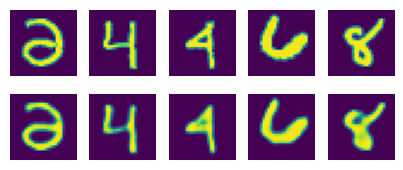

In [40]:
# 컴파일 및 학습을 하는 부분입니다.
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(X_train, X_train, epochs=50, batch_size=128, validation_data=(X_test, X_test))

# 학습된 결과를 출력하는 부분입니다.
random_test = np.random.randint(X_test.shape[0], size=5)  # 테스트할 이미지를 랜덤하게 불러옵니다.
ae_imgs = autoencoder.predict(X_test)                     # 앞서 만든 오토인코더 모델에 집어 넣습니다.

plt.figure(figsize=(7, 2))                         # 출력될 이미지의 크기를 정합니다.

for i, image_idx in enumerate(random_test):       # 랜덤하게 뽑은 이미지를 차례로 나열합니다.
  ax = plt.subplot(2, 7, i + 1) 
  plt.imshow(X_test[image_idx].reshape(28, 28))   # 테스트할 이미지를 먼저 그대로 보여줍니다.
  ax.axis('off')
  ax = plt.subplot(2, 7, 7 + i +1)
  plt.imshow(ae_imgs[image_idx].reshape(28, 28)) # 오토인코딩 결과를 다음열에 출력합니다.
  ax.axis('off')
plt.show()